In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../PostBornEma/'

In [3]:
data = np.loadtxt(path+'FFT_k-1Pk.dat',skiprows=2)

#----------------------#
n         = data[:,0]
Re_c_n    = data[:,1]
Im_c_n    = data[:,2]
Re_nu_n   = data[:,3]
Im_nu_n   = data[:,4]
#----------------------#

c_n  = Re_c_n  + 1j * Im_c_n
nu_n = Re_nu_n + 1j * Im_nu_n

In [4]:
# for cl psipsi
data =  np.load(path+'Il_nu_t_new1-ell-nn-tt.npy')
ell       = data[:,0]
nn        = data[:,1]
tt        = data[:,2]
#----------------------#

data =  np.load(path+'Il_nu_t_new1-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_0 = Re_I + 1j * Im_I


In [5]:
#for cl psi delta
data =  np.load(path+'Il_nu_t_nd2-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_2 = Re_I + 1j * Im_I


# for cl delta delta
data =  np.load(path+'Il_nu_t_nd4-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_4 = Re_I + 1j * Im_I



In [6]:
del Re_I, Im_I, data

In [7]:
#shrink
ell_ = np.unique(ell)
nu_n_= np.unique(nu_n) 
t_   = np.unique(tt)



#make 3D arrays 
ell = ell.reshape(ell_.size, nu_n_.size, t_.size)
nn  = nn.reshape(ell_.size, nu_n_.size, t_.size)
tt  = tt.reshape(ell_.size, nu_n_.size, t_.size)
I_0 = I_0.reshape(ell_.size, nu_n_.size, t_.size)
I_2 = I_2.reshape(ell_.size, nu_n_.size, t_.size)
I_4 = I_4.reshape(ell_.size, nu_n_.size, t_.size)

cn2 = c_n.copy()
cn2[:-1] *=2

#insert a new axis for r and multiply with c_n 
I0_lcrt = np.expand_dims(I_0, 2)*cn2.reshape(1, -1, 1, 1)
I2_lcrt = np.expand_dims(I_2, 2)*cn2.reshape(1, -1, 1, 1)
I4_lcrt = np.expand_dims(I_4, 2)*cn2.reshape(1, -1, 1, 1)

#change t and c
I0_ltrc = np.swapaxes(I0_lcrt, 1, 3)
I2_ltrc = np.swapaxes(I2_lcrt, 1, 3)
I4_ltrc = np.swapaxes(I4_lcrt, 1, 3)


In [8]:
del I_0, I_2, I_4

In [9]:
#get Gaussian quadrature weights
data = np.loadtxt(path+'GG_weights.dat',skiprows=2)
t1   = data[:,0]
w1   = data[:,1]
assert(np.allclose(t_,t1))


In [10]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)

# speed of light
c      = 299792458./1000. # km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [11]:
#interpolation splines for redshift and distance
from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]
class_D               = cosmo_b['gr.fac. D'][::-1]
class_H               = cosmo_b['H [1/Mpc]'][::-1]/h #already divided by c
derivParams           = cosmo.get_current_derived_parameters(['z_rec'])

dchi_dz=(class_chi[1::]-class_chi[0:-1])/(class_z[1::]-class_z[0:-1])*h
z_mean = (class_z[1::]+class_z[0:-1])/2

z_cmb                 = derivParams['z_rec']


from scipy.interpolate import interp1d
chi_z = interp1d(class_z,class_chi*h,fill_value=0, bounds_error=False)
z_chi = interp1d(class_chi*h,class_z,fill_value=0, bounds_error=False)  # Mpc/h
D_chi = interp1d(class_chi*h,class_D,fill_value=0, bounds_error=False)    # growth
D_z   = interp1d(class_z,class_D,fill_value=0, bounds_error=False)
# chi_cmb
chi_cmb = chi_z(z_cmb)

dz_dchi = interp1d(class_chi*h,class_H,fill_value=0, bounds_error=False)
dchi_dz = interp1d(z_mean,dchi_dz,fill_value=0, bounds_error=False)


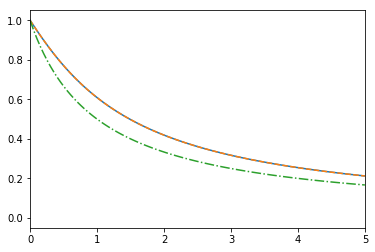

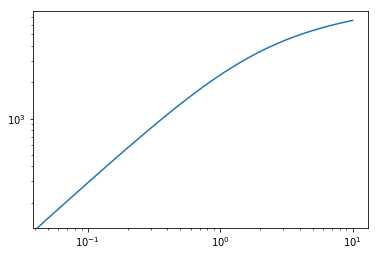

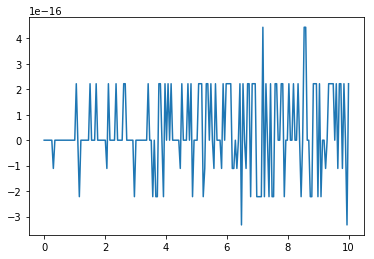

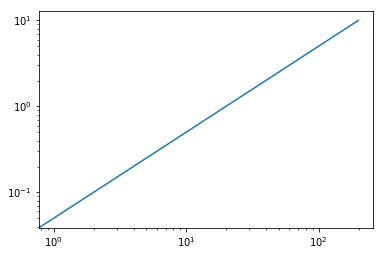

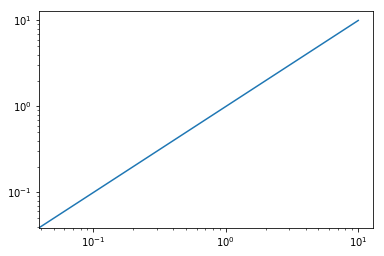

(200,) (200,)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in reciprocal


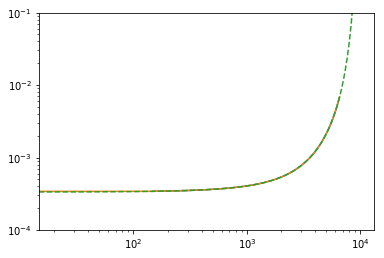

In [12]:
# sanity checks
z = np.linspace(0,5,100)
chi = chi_z(z)
plt.figure()
plt.plot(class_z,class_D,ls='-')
plt.plot(z,D_z(z),ls='--')
plt.plot(z,1/(1+z),ls='-.')
plt.xlim(0,5)
plt.show()
D_z(0)
z=np.linspace(0.,10,200)
chi = chi_z(z)
plt.figure()
plt.loglog(z,chi_z(z))
plt.show()

plt.figure()
plt.plot(z,D_z(z)/D_chi(chi_z(z))-1.)
plt.show()
plt.figure()
plt.loglog(z,)
plt.show()
plt.figure()
plt.loglog(z,z_chi(chi_z(z)))
plt.show()
print(z.shape,chi.shape)
plt.figure()
plt.loglog(chi,dchi_dz(z)**(-1))
plt.loglog(chi,dz_dchi(chi))
plt.loglog(class_chi*h,class_H,ls='--')
plt.ylim(1e-4,1e-1)
plt.show()

# Integrals

In [13]:
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
import time


In [14]:
# CL^kk following Eq. 3.5 in https://arxiv.org/abs/1705.05022

def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
#I0_ltrc  = np.swapaxes(I0_lcrt, 1, 3)


begin=time.time()

chi1fac0 = (lensing_kernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb))
chi1fac0 = chi1fac0 *(r2d*chi_cmb)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (lensing_kernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1./t2d*chi_cmb))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I0_ltrc[ii])

Cl=chi_cmb * result*1./np.pi**2*prefac**2/2.

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.3545126914978027


We have integrals of the form (for example, take the second term of $C_{22shift}^{\kappa g}$ i.e. eq. 4.2; drop the integral over $\ell$):
<br>
\begin{eqnarray}
Target &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\Phi \Psi}(\chi', \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'} d\chi" W(\chi", \chi') C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Now,
\begin{eqnarray}
C_l^{ab}(\chi_1, \chi_2) &=& \int \frac{dk}{k} j_l(k\chi_1)j_l(k\chi_2) [k^3 P^{ab}(k, \chi_1, \chi_2)] \\
&=& \sum_n c_n \chi_1 ^{-\nu_n} I_l(\nu_n, \frac{\chi_2}{\chi_1})
\end{eqnarray}

So, 
\begin{eqnarray}
Target &=& \int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') \\
&\times& \Big(\int_0^{\chi'} d\chi" W(\chi", \chi') \sum_n c^{ab}_n \chi ^{-\nu_n} I_{l1}^{ab}(\nu_n, \frac{\chi''}{\chi}) \Big) \\
&\times& \Big(\int_0^{\chi} d\chi''' W(\chi''', \chi) \sum_n c^{cd}_n \chi' ^{-\nu_n} I_{l2}^{cd}(\nu_n, \frac{\chi'''}{\chi'}) \Big)
\end{eqnarray}

These are coupled together in complicated way amongst the 4 $\chi$. 
<br>
I think the best way to estimate these are to save the array - 
$$
\int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) 
$$
in the above above equation as a matrix $G(l, \chi, \chi')$.
<br>
This then reduces the evaluation of integrals to the sum - 
\begin{eqnarray}
Target &=& \int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') \times G^{ab}(l_1, \chi', \chi)\times G^{cd}(l_2, \chi, \chi')\\
\end{eqnarray}
which we can evaluate as a Gauss Qaud sum.

To save $G^{cd}(l_2, \chi, \chi')$, we have -

\begin{eqnarray}
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) \\
t &=& \chi ''/\chi' \\
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi/\chi'} dt W(t\chi', \chi) \sum_n c_n \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
G^{cd}(l, \chi, \chi') &=& \sum_n  \int_0^1 dt \big( c_n(\chi', t\chi') (W(t\chi', \chi) + t^{-\nu-2} c_n(\chi', \chi'/t) W(\chi'/t, \chi) \big) \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
\end{eqnarray}

__The problem here is that $t$ is fixed. And the obvious values of $\chi$ and $\chi'$ that we should take are $t \chi_{CMB}$. Hence I am a bit uncertain how well are we sampling this integral anymore in going from $\chi/\chi'$ to (0-1) limit. But it should work since that is what we do in the Cl_kk as well
__

In [15]:
### Estimate as function of 'chi' and then integrate over \chi
###This is a test to check that we can estimate Cl_kk with this accurately, which kind of justifies that we are estimating
###The G matrix accurately.

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


chimax = chi_cmb
chi1s  = t_*chimax

chi1fac0 = (lensing_kernel(chi1s, chimax))#*D_chi(chi1s)) #Move this inside the sum
#ltc
t2d    = t_.reshape(1, -1, 1)
#get rid of r -axis
I0_ltc = np.squeeze(I0_ltrc)

begin = time.time()
result = []
for ii, chi in enumerate(chi1s):
    
    chifac    = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop
    
    chi2fac00 = (lensing_kernel(t2d*chi, chimax)*D_chi(t2d*chi))
    chi2fac01 = (lensing_kernel(1./t2d*chi, chimax)*D_chi(1./t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01
    fac       = w1.reshape(1, -1, 1)*chi2fac0*chifac
    integrand = fac * I0_ltc
    result.append(integrand.sum(axis = (1, 2)))

result = np.array(result)
print(result.shape)
result = (result*chi1fac0.reshape(-1, 1)*w1.reshape(-1, 1)).sum(axis=0)
Cl2=chimax * result*1/np.pi**2*prefac**2/2.

print('Time taken = ', time.time()-begin)

(100, 289)
Time taken =  3.071491241455078


In [16]:
mean = 3
width = 0.5
cosmo_dict['output']='nCl, lCl, tCl, sCl, mPk'
cosmo_dict['lensing']='yes'
cosmo_dict['selection']='gaussian'
cosmo_dict['selection']='gaussian'
cosmo_dict['selection_mean'] = str(mean)
cosmo_dict['selection_width'] = str(width)
cosmo_dict['l_switch_limber']=100
cosmo_dict['perturb_sampling_stepsize']=0.01
cosmo_dict['P_k_max_1/Mpc']=10.

cosmo.empty()
cosmo.set(cosmo_dict)
cosmo.compute()

In [17]:
cldd = cosmo.density_cl(300)
cllen = cosmo.lensed_cl(2000)



/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(2, 500)

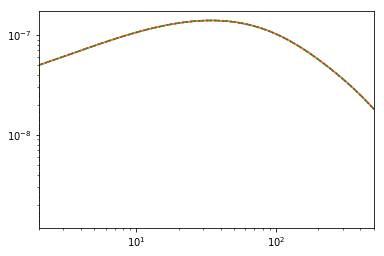

In [18]:
ll,clpp,clpp2 = np.loadtxt('class_ouput.out')
plt.figure()
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi))
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi))
plt.loglog(ll,(ll*(ll+1.))**2*clpp/(2.*np.pi),ls='--')
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp'])/(2.*np.pi),ls=':')
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl3[:lmax]/(2.*np.pi))
plt.xlim(2,500)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


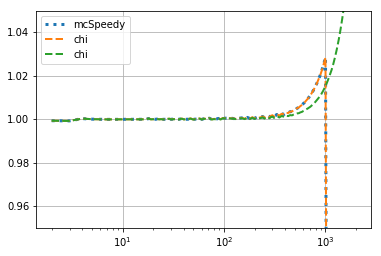

In [19]:
ll,clpp,clpp2 = np.loadtxt('class_ouput.out')

plt.figure()
plt.semilogx(ell_,Cl/np.interp(ell_,ll,clpp), ls=":", lw=3, label='mcSpeedy')
plt.semilogx(ell_,Cl2/np.interp(ell_,ll,clpp), ls="--", lw=2, label='chi')
plt.semilogx(ell_,Cl2/np.interp(ell_,cllen['ell'],cllen['pp']), ls="--", lw=2, label='chi')
plt.ylim(0.95,1.05)
# plt.ylim(0.9,2)
plt.grid()
plt.legend()

# save xifunc as described above

To save $G^{cd}(l_2, \chi, \chi')$, we have -

\begin{eqnarray}
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) \\
t &=& \chi ''/\chi' \\
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi/\chi'} dt W(t\chi', \chi) \sum_n c_n \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
G^{cd}(l, \chi, \chi') &=& \sum_n  \int_0^1 dt \big( c_n(\chi', t\chi') (W(t\chi', \chi) + t^{-\nu-2} c_n(\chi', \chi'/t) W(\chi'/t, \chi) \big) \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
\end{eqnarray}

__The problem here is that $t$ is fixed. And the obvious values of $\chi$ and $\chi'$ that we should take are $t \chi_{CMB}$. Hence I am a bit uncertain how well are we sampling this integral anymore in going from $\chi/\chi'$ to (0-1) limit. But it should work since that is what we do in the Cl_kk as well
__

In [20]:
# ### Saving here

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))

# I4_ltc = np.squeeze(I4_ltrc)
# t2d = t_.reshape(1, -1, 1)

# chis = t_*chi_cmb
# chips = t_*chi_cmb

# Gsave = []

# begin = time.time()
# for ichim, chimax in enumerate(chis[:]):
#     if ichim %10 == 0:
#         print(ichim)
        
#     chi1fac0 = (Wkernel(chips, chimax))#*D_chi(chi1s)) #Move this inside the sum

#     result = []
#     for ii, chi in enumerate(chips):

#         chifac = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop

#         chi2fac00 = (Wkernel(t2d*chi, chimax)*D_chi(t2d*chi))
#         chi2fac01 = (Wkernel(1/t2d*chi, chimax)*D_chi(1/t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
#         chi2fac0 = chi2fac00 + chi2fac01
#         fac = w1.reshape(1, -1, 1)*chi2fac0*chifac
#         integrand = fac * I4_ltc
#         result.append(integrand.sum(axis = (1, 2)))

#     Gsave.append(np.array(result).T)
#     if ichim %10 == 0:
#         print(time.time()-begin)
    
# Gsave = np.swapaxes(np.array(Gsave), 0, 1)

# np.save(path + 'G-Ilnut_nd4', Gsave)

# Clgg

In [21]:
# Chirag's kernel definition
def old_kernel(z0, sigz=0.3):
    z1, z2   = z0-sigz/2., z0+sigz/2.
    xi1, xi2 = chi_z(z1), chi_z(z2)
    sigxi    = xi2-xi1
    xi0     = chi_z(z0)
    def kernel(xi):
        return 1./np.sqrt(2*np.pi*sigxi**2) * np.exp(- (xi-xi0)**2/2/sigxi**2) 
    return kernel

# general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel

# kernel as in paper?
def Gauss_chi(z0,sigma_z,chimax=5):
    chi0      = chi_z(z0)
    sigma_chi = sigma_z/dz_dchi(chi0)
    def chi_kernel(chi):
        return 1./np.sqrt(2.*np.pi)/sigma_chi*np.exp(-(chi-chi0)**2/2./sigma_chi**2)
    return chi_kernel
    

# supports redshift dependent bias, for now: constant
def bias_chi(chi):
    return 1.9

    
#First kernel
###############################################################lcr##########
#Set up

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
I4_ltrc  = np.swapaxes(I4_lcrt, 1, 3)


#Redshift kernels

# uncomment to reproduce left upper plot
#z10, z20, sigz = 1., 1., 0.05

z10, z20, sigz = 1., 1.25, 0.5

kernel1 = old_kernel(z10,sigz)
kernel2 = old_kernel(z20,sigz)

#first kernel
#########


begin=time.time()
#Try different chimax to see how sampling changes things
chimax   = chi_z(z20+5.*sigz)

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*bias_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*bias_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*bias_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])
    

Clgg = chimax * result*1./np.pi**2/2.

print('Time taken = ', time.time()-begin)


#Second kernel
###################################
begin=time.time()
kernel1 = Gauss_chi(z10,sigz)
kernel2 = Gauss_chi(z20,sigz)

chimax  = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*bias_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*bias_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax)*bias_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clggcmb = chimax * result/np.pi**2/2.

print('Time taken = ', time.time()-begin)

#third kernel
###################################
begin=time.time()
kernel1 = gal_kernel(Gauss_redshift(z10,sigz))
kernel2 = gal_kernel(Gauss_redshift(z20,sigz))

chimax = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*bias_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*bias_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax)*bias_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clggcmb_2 = chimax * result/np.pi**2/2.

print('Time taken = ', time.time()-begin)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4110970497131348


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:109: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.4181110858917236


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:137: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.443049430847168


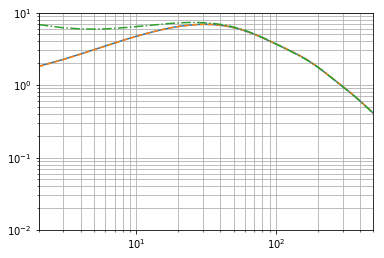

In [22]:
# uncomment for plotting left upper plot

# plot for 3 different kernel definitions (chirag's, paper and mine)
# result is very sensitive to kernel, but also off by a factor of a few
# plt.plot(ell_, abs(Clgg)*1e6/4./np.pi)
# plt.plot(ell_, abs(Clggcmb)*1e6/4./np.pi,ls='--')
# plt.plot(ell_, abs(Clggcmb_2)*1e6/4./np.pi,ls='-.')
# plt.loglog()
# plt.ylim(0.3, 12)
# # plt.yticks((0.5, 1, 2, 5, 10), (0.5, 1, 2, 5, 10))
# #plt.yticks(np.logspace(-2, 2, 5), np.logspace(-2, 2, 5))
# plt.xlim(2, 500)
# plt.grid(which='both')

# plotting upper righ plot in Fig 2. Differnce seems a factor of 1/4/pi
plt.plot(ell_, abs(Clgg)*1e7/4./np.pi)
plt.plot(ell_, abs(Clggcmb)*1e7/4./np.pi,ls='--')
plt.plot(ell_, abs(Clggcmb_2)*1e7/4./np.pi,ls='-.')
plt.loglog()
plt.ylim(0.01, 10)
# plt.yticks((0.5, 1, 2, 5, 10), (0.5, 1, 2, 5, 10))
#plt.yticks(np.logspace(-2, 2, 5), np.logspace(-2, 2, 5))
plt.xlim(2, 500)
plt.grid(which='both')

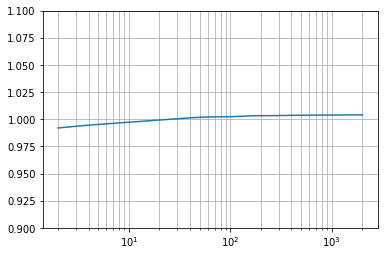

In [23]:
plt.plot(ell_, Clggcmb/Clgg)
plt.xscale('log')
plt.ylim(0.90, 1.1)
plt.grid(which='both')

In [24]:
# computing clkk from Pk_m, approximation where los derivatives are neglected

def lensing_kernel_2(xi, xmax):
    return (xmax - xi)/(xmax)*xi* (xmax > xi) * (1.+z_chi(xi))

kernel = lensing_kernel_2

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
I4_ltrc  = np.swapaxes(I4_lcrt, 1, 3)

begin=time.time()
#Try different chimax to see how sampling changes things
chimax   = chi_cmb

chi1fac0 = (kernel(r2d*chimax,chi_cmb)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel(t2d*r2d*chimax,chi_cmb)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel(1./t2d*r2d*chimax,chi_cmb)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])
    

Clkk = chimax * result*1./np.pi**2/2.*prefac**2

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.49871826171875


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


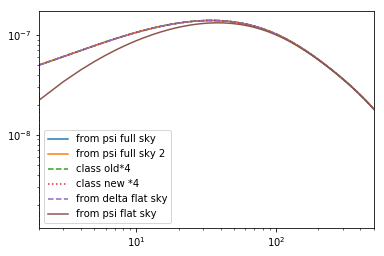

In [25]:
# difference to full sky is not as bad as to flat sky (this is also noted in the Kilbinger (Kitching?) paper for the Limber approximation)
plt.figure()
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi),label='from psi full sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi),label='from psi full sky 2')
plt.loglog(ll,(ll*(ll+1.))**2*clpp/(2.*np.pi),ls='--', label='class old*4')
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp'])/(2.*np.pi),ls=':',label='class new *4')
plt.loglog(ell_[:lmax],Clkk[:lmax]/(2.*np.pi),ls='--',label='from delta flat sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]))**2*Cl2[:lmax]/(2.*np.pi),label='from psi flat sky')
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl3[:lmax]/(2.*np.pi))
plt.xlim(2,500)
plt.legend()
plt.show()


# Integrals

\begin{eqnarray}
C_l^{ab}(\chi_1, \chi_2) &=& \int \frac{dk}{k} j_l(k\chi_1)j_l(k\chi_2) [k^3 P^{ab}(k, \chi_1, \chi_2)] \\
&=& \sum_n c_n \chi_1 ^{-\nu_n} I_l(\nu_n, \frac{\chi_2}{\chi_1})
\end{eqnarray}
(dropped 1/$4\pi$)

\begin{eqnarray}
G^{ab}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) C_l^{ab}(\chi', \chi")  \\
&=&\int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l^{ab}(\nu_n, \frac{\chi''}{\chi'}) 
\end{eqnarray}
<br>


In the following, drop the integral over $\ell$

- $C_{22shift, A}^{\kappa g}$ i.e. eq. 4.2 first term :
<br>
\begin{eqnarray}
C_{22shift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here, we can create a table of ($\chi, \chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') $, then simply multiply with other $I_{l1}^{\delta \Psi}$ and do the remaining 2 integrals with GC
 

- $C_{22shift, B}^{\kappa g}$ i.e. eq. 4.2 second term :
<br>
\begin{eqnarray}
C_{22shift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\Phi \Psi}(\chi', \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'} d\chi" W(\chi", \chi') C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

<span style="color:blue">VB: checked above equations</span>


Notes - here, we can create use table of $G_{l_2, \chi, \chi'}^{\delta \Psi}$ and $G_{l_1, \chi, \chi'}^{\Psi \Psi}$, multiply them and then do the the remaining 2 integrals with GC

- $C_{13ashift, A}^{\kappa g}$ i.e. eq. 4.3 :
<br>
\begin{eqnarray}
C_{13ashift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi, \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 22A, we can create a table of ($\chi$) for the second half i.e. $\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi, \chi''') $, put it in the kernel of $\chi$; integrate out $\chi'$ first with GC and then do the full $\chi$ integral with GC


- $C_{31ashift, B}^{\kappa g}$ i.e. eq. 4.4 :
<br>
\begin{eqnarray}
C_{31ashift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\Phi \Psi}(\chi, \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi} d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here again, we can do integral over $\chi'$ and $\chi"$ trivially, combine everything into the kernel of $\chi$ and then estimate that with GC


- $C_{13shift}^{\kappa g}$ i.e. eq. 4.5 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 31a,A, except we can create a table of ($\chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') $, put it in the kernel of $\chi'$; then integrate out $\chi'$ and $\chi$ in the usual manner


- $C_{13shift}^{\kappa g}$ i.e. eq. 4.6 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta}(\chi", \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') 
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi)
\int_0^{\chi"} d\chi''' W(\chi''', \chi") C_{l2}^{\Psi\delta}(\chi''', \chi')  
\end{eqnarray}

Notes - here we can do the $\chi', \chi'''$ integrals first  in the usual fashion to create a table of $\chi"$ and then use them as weights to do $\chi, \chi''$ integrals later

- $C_{31bshift}^{\kappa g}$ i.e. eq. 4.6-3.7 :
<br>
\begin{eqnarray}
C_{31bshift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta}(\chi", \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') 
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi)
\int_0^{\chi"} d\chi''' W(\chi''', \chi") C_{l2}^{\Psi\delta}(\chi''', \chi')  
\end{eqnarray}

Notes - here we can do the $\chi', \chi'''$ integrals first  in the usual fashion to create a table of $\chi"$ and then use them as weights to do $\chi, \chi''$ integrals later

- $C_{13bshift}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) ...
\end{eqnarray}

Notes - ...

- $C_{13, J}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta} ...
\end{eqnarray}

Notes - ...

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


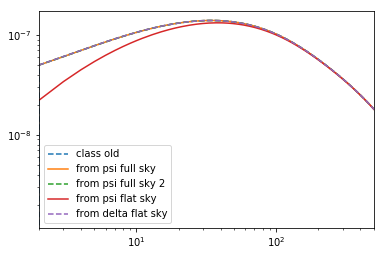

In [26]:

plt.figure()
#full sky
plt.loglog(ll,(ll*(ll+1.))**2*clpp/(2.*np.pi),ls='--',label='class old')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi),label='from psi full sky')
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi),label='from psi full sky 2', ls ='--')
#flat sky
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]))**2*Cl2[:lmax]/(2.*np.pi),label='from psi flat sky')
plt.loglog(ell_[:lmax],Clkk[:lmax]/(2.*np.pi),ls='--',label='from delta flat sky')
plt.legend()
plt.xlim(2,500)
plt.show()

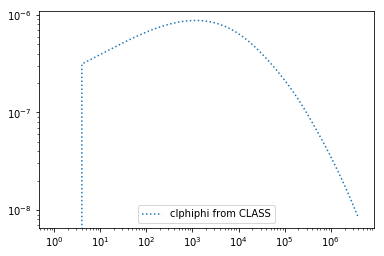

In [27]:
plt.loglog(cllen['ell']*cllen['ell'],(cllen['ell']*(cllen['ell']+1))**2*cllen['pp'],ls=':',label='clphiphi from CLASS')
plt.legend()

In [28]:
# general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel

#third kernel
###################################
begin=time.time()
kernel1 = gal_kernel(Gauss_redshift(mean,width))
kernel2 = gal_kernel(Gauss_redshift(mean,width))

chimax = chi_cmb

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg_c = chimax * result/np.pi**2/2.

print('Time taken = ', time.time()-begin)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.452423095703125


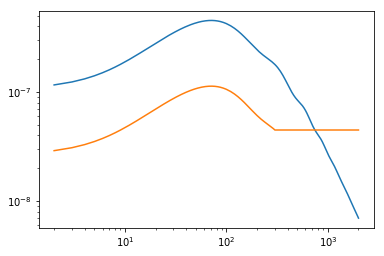

In [29]:

plt.loglog(ell_, Clgg_c)
plt.loglog(ell_,np.interp(ell_,cldd['ell'],cldd['dd'][0]))

(0, 1.1)

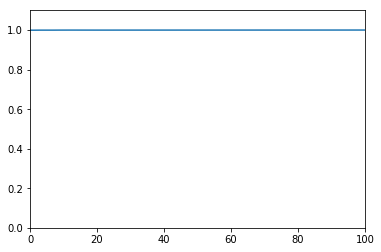

In [30]:
plt.plot(np.interp(ell_,cldd['ell'],cldd['dd'][0])/Clgg_c*4)
plt.xlim(0,100)
plt.ylim(0,1.1)

In [31]:
print(1./(np.interp(ell_,cldd['ell'],cldd['dd'][0])/Clgg_c))

[4.00065118 4.00164096 4.00029088 4.0003037  4.00060303 3.99944659
 3.99999536 4.00015801 3.99927358 3.99948015 4.00004037 3.99959779
 3.99908251 3.99941173 3.99986982 3.9996601  3.9991432  3.99905191
 3.99943869 3.99974798 3.9996024  3.99917061 3.99888759 3.99898055
 3.99931073 3.99956077 3.99952429 3.99923706 3.99890917 3.99875264
 3.99884442 3.99910543 3.99937243 3.9994995  3.99943031 3.99921071
 3.99895039 3.99876458 3.99872463 3.99883601 3.99904544 3.99926989
 3.99942994 3.99947626 3.99940205 3.99923794 3.99903742 3.99885816
 3.99874544 3.99872259 3.99878755 3.99891635 3.99907209 3.99921543
 3.99931442 3.99935005 3.99931835 3.99922941 3.99910371 3.99896677
 3.99884472 3.99875878 3.99872216 3.99873804 3.99880062 3.99889692
 3.99900978 3.99912181 3.9992171  3.9992833  3.9993131  3.99930441
 3.99926062 3.99918881 3.99909913 3.99900411 3.99891596 3.99884506
 3.99879897 3.9987815  3.9987928  3.99882982 3.99888683 3.99895725
 3.99903363 3.99910831 3.99917393 3.99922387 3.9992541  3.9992

# Cross Correlations

computing $C_L^{\kappa g}$ in post Limber and compare to Limber results

In [32]:
# set up (as before), but using FFTlog of P_deltapsi

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel
kernel2  = gal_kernel(Gauss_redshift(mean,width))

n = 2

begin=time.time()



chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I2_ltrc[ii])
    

Cl_kg = chimax * result*1./np.pi**2/2.*prefac

print('Time taken = ', time.time()-begin)


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.3626441955566406


<function matplotlib.pyplot.loglog(*args, **kwargs)>

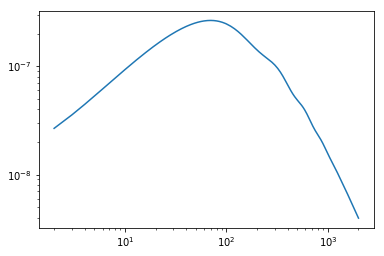

In [33]:
plt.loglog(ell_[:lmax],ell_[:lmax]*(ell_[:lmax]+1.)*Cl_kg[:lmax])
#plt.loglog(ll,clpp,ls='--', label='class old*4')
plt.loglog

In [34]:
# cross in Limber
chis = np.linspace(1.,chi_cmb,5000) #in Mpc/h
ells = np.linspace(1,2000,200)
result=[]
for l_ in ells:
    integrand=[]
    for chi in chis:
        k = l_/chi #in h/Mpc
        try:
            Pk= cosmo.pk(k*h,0.)*D_chi(chi)**2*h**3
        except:
            Pk= 0.
        integrand+=[lensing_kernel(chi,chi_cmb)*kernel2(chi)*Pk]
    result+=[np.trapz(integrand, chis)]
clkg=np.asarray(result)*prefac

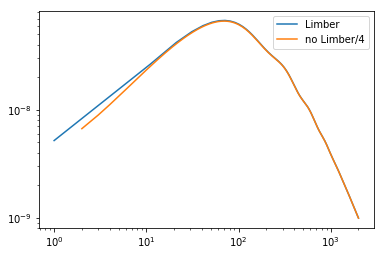

In [35]:
#same factor of four as before, disagreement at low ell is expected
plt.loglog(ells,clkg*(ells+1.)/ells,label='Limber')
plt.loglog(ell_[:lmax],ell_[:lmax]*(ell_[:lmax]+1.)*Cl_kg[:lmax]/4.,label='no Limber/4')
plt.legend()

In [36]:
# set up (as before), but using FFTlog of P_deltadelta, i.e. lensing kernel 2, should give better match to no Limber, also we should recover factor 0f 4

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel_2
kernel2  = gal_kernel(Gauss_redshift(mean,width))

n = 4

begin=time.time()



chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])
    

Cl_kg2 = chimax * result*1./np.pi**2/2.*prefac

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.427227258682251


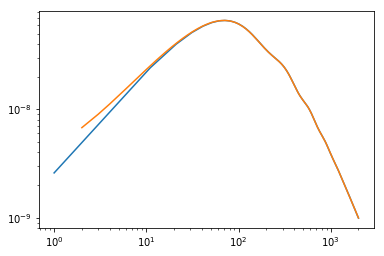

In [37]:
plt.loglog(ells,clkg,label='Limber')
plt.loglog(ell_[:lmax],Cl_kg2[:lmax]/4.,label='no Limber')

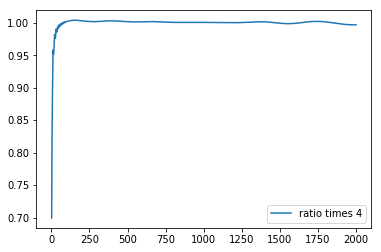

In [38]:
plt.plot(ell_[:lmax],np.interp(ell_[:lmax],ells,clkg)/Cl_kg2[:lmax]*4,label='ratio times 4')
plt.legend()

# Cls on grids for post Born integrals

### $C_L^{\phi\phi}(\chi,\chi')$ (appears eg. in Eqs. (4.2))

In [39]:
# this is the factor that input files seem to be offsetted by
fudge = 0.25

In [40]:
def phi_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))

#### for $\chi_{max}=\chi_{CMB}$

In [41]:
# this is Chirags version, which loops over the inner integral 
chimax = chi_cmb
chi1s  = t_*chimax

chi1fac0 = phi_kernel(chi1s, chimax)

t2d      = t_.reshape(1, -1, 1)
#get rid of r -axis
I0_ltc   = np.squeeze(I0_ltrc)

begin = time.time()
result = []

#outer chis
for ii, chi in enumerate(chi1s):
    
    chifac    = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop
    
    chi2fac00 = (phi_kernel(t2d*chi, chimax)*D_chi(t2d*chi))
    chi2fac01 = (phi_kernel(1./t2d*chi, chimax)*D_chi(1./t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01
    fac       = w1.reshape(1, -1, 1)*chi2fac0*chifac
    integrand = fac * I0_ltc
    
    result.append(integrand.sum(axis = 2))

result = np.swapaxes(np.array(result),0,1)

result = (result*chi1fac0.reshape(1, -1, 1)*w1.reshape(1,-1, 1))*chimax/np.pi**2/2.*prefac**2
print(result.shape)
Cl2      = result.sum(axis=(1,2))

print('Time taken = ', time.time()-begin)

(289, 100, 100)
Time taken =  3.7189764976501465


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


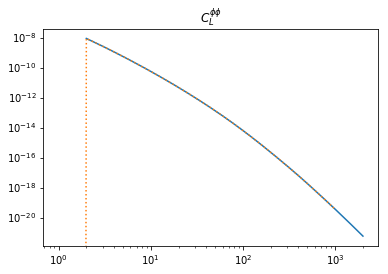

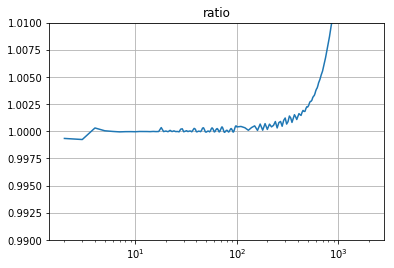

In [42]:
# make test plot
plt.title('$C_L^{\phi\phi}$')
plt.loglog(ell_,Cl2, label = 'our result, post Limber')
plt.loglog(ll,np.interp(ll,cllen['ell'],cllen['pp']),ls=':',label='class, post Limber')
plt.show()

plt.title('ratio')
plt.semilogx(ell_,Cl2/np.interp(ell_,cllen['ell'],cllen['pp']))
plt.ylim(0.99,1.01)
plt.grid()
plt.show()

sub-percent accuracy down to L=800 (I have canceled factor of 2 in $\phi=2\int...$ and fudge factor, and dont code them)

but we don't need the split as it is in cell 103! We want to loop over the upper integration boundary.

#### now with varying $\chi_{max}$ for Eq. (4.2)

In [43]:
# test case for expanding by first chimax axis, multiply time by 100 to get total time for varying both integration boundaries
chi1s = np.ones(100)*chi_cmb #for real case replace this by t_*chi_cmb
r2d, t2d, chimax1 = np.meshgrid(t_,t_,chi1s)
w11, w12, _ = np.meshgrid(w1,w1,chi1s)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
chimax1 = np.expand_dims(chimax1,2)
I0_ltrcx = np.expand_dims(I0_ltrc,5)


print(chimax1.shape)

#chi_max1=chi_cmb #maximum for r*chi
chi_max2=chi_cmb #maximum for t*chi

begin=time.time()

#Cl = np.zeros((ell_.size,100,100))

# for ii, chi_max1 in enumerate(chi1s):
#     print(ii)
#     for jj, chi_max2 in enumerate(chi1s):
chi1fac0 = (lensing_kernel(r2d*chi1s, chi1s)*D_chi(r2d*chi1s))
chi1fac0 = chi1fac0 *(r2d*chi1s)**(1-nu_n_.reshape(1, 1, -1, 1))

#print(r2d.shape,chimax1.shape,lensing_kernel(r2d*chi_max1, chi_max1).shape)

chi2fac00 = (lensing_kernel(t2d*r2d*chi_max2, chi_max2)*D_chi(r2d*t2d*chi_max2))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_max2, chi_max2)*D_chi(r2d*1./t2d*chi_max2))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1,1)-2)
chi2fac0  = chi2fac00 + chi2fac01
del chi2fac00
del chi2fac01
chifacs   = w11*w12*chi1fac0* chi2fac0

# print(chifacs.shape)
Cl =[]
lmax = ell_.size
for nn  in range(20):    
    print(nn)
    Cl+=[np.sum(chifacs*I0_ltrcx[nn],axis=(0,1,2))*chi1s *1./np.pi**2*prefac**2/2.]

print('Time taken = ', time.time()-begin)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':


(100, 100, 1, 100)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Time taken =  50.93895435333252


In [44]:
Cl = np.asarray(Cl)
Cl.shape


(20, 100)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


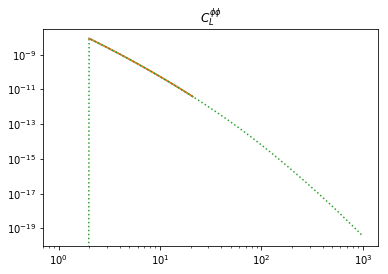

In [45]:
# make test plot
plt.title('$C_L^{\phi\phi}$')
plt.loglog(ell_[0:20],Cl[:,0], label = 'our result, post Limber')

plt.loglog(ell_[0:20],Cl[:,-1], label = 'our result, post Limber 2')

plt.loglog(ll,np.interp(ll,cllen['ell'],cllen['pp']),ls=':',label='class, post Limber')
plt.show()

### 

# Starting Vanessa's implementation of $G^{ab}$s

### 1) $ G_l^{\phi\psi}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\psi}(\chi_1,\chi_2)$ 
$= \mathcal{A}^2 \frac{1}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} [1+z(\chi_2)] D(\chi_2) I_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{\nu_n-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

needs to be evaluated for varying $\chi_{max}$ and $\chi_2$ (this appears in Eq. 4.2).

replacing $\chi_2$ by $r\chi_{max}$ allows doing basically the same as before, just without summing over $r$,
so that the ouput for fixed $\chi_{max}$ has shape of $r$.
Then we only need one loop over $\chi_{max}$.

In [113]:
import time
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) #* (1.+z_chi(xi))

chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
#I0_ltrc  = np.swapaxes(I0_lcrt, 1, 3)

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi1_max)):
    if jj%10==0:
        print(jj)
    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max)*lensing_kernel(r2d*t2d*chi2_max, chi1_max)))
    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))
    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = chi1fac0* chi2fac0*w12

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    Cl[jj]=result*1./np.pi**2*prefac**2/2./2. #divide by another factor of 2 because of Gaussian quadrature

# swap axes to have cl_phipsi_l(chi_max,chi)
Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  143.4705035686493


to get $C_l^{\phi\phi}(\chi_1,\chi_2)$ we only need to do one more looped integral:

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})= \int_0^{\chi_{max2}} \mathrm{d}\chi_2  W(\chi_2,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_2)$

with loop over $\chi_{max2}$

with parametrization by $r$ and Gaussian quadrature this becomes

$C_l^{\phi\phi}(\chi_{max1},\chi_{max2})=\chi_{max2} \int_0^{1} \mathrm{d} r  W(\chi_{max2} r ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r)= \chi_{max2} / 2 \sum_{r_{i}} w_i W(\chi_{max2} r_{i} ,\chi_{max2}) C_l^{\phi\psi}(\chi_{max1},\chi_{max2} r_{i})$

In [116]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)


chi2_max = chi_cmb
result = np.zeros((len(t_),len(ell_),len(t_)))
for jj, chi2_max in enumerate((chi2_max*t_)):

    result[jj] = chi2_max/2.*np.sum(w1*Cl*lensing_kernel(chi2_max*t_,chi2_max), axis=2) #should work according to numpy broadcasting rules

result=result.swapaxes(0,1)

np.save('../G_matrices/clphiphi',result*4.)

(1, 2000)

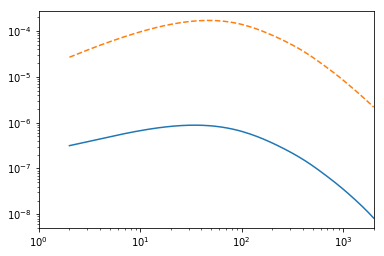

In [117]:
#lets check if we get the correct result when we look at the last entry where chi_max=chi_cmb
clphiphi = result[:,-1,-1]
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*clphiphi,ls='--')
plt.loglog()
plt.xlim(1,2000)
#--> not working yet 

### tesing gaussian quadrature with simple integral test
$\int_0^1 \mathrm{d} x x^2 = 1/2 \sum_i w_i t_i^2 = 1/3 $

In [118]:
0.5*np.sum(w1*t_**2)

0.33333333387229197

In [119]:
# loading Chirags results
clphiphi2 = np.zeros((len(t_),len(ell_),len(t_)))
path = '../scripts/output/clphiphi/'
for ii in range(len(t_)):
    clphiphi2[ii] = np.loadtxt(path+'%d.txt'%ii)[:,1:]
clphiphi2=np.swapaxes(clphiphi2,0,1)

In [120]:
clphiphi2_ = clphiphi2[:,-1,-1]

(1, 2000)

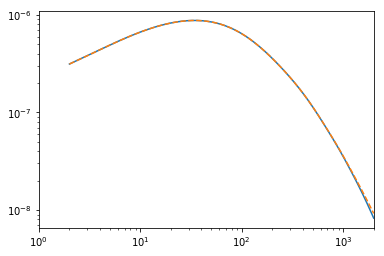

In [121]:
# Chirags results match Class perfectly at chi_max=chi_cmb
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*clphiphi2_,ls='--')
plt.loglog()
plt.xlim(1,2000)

In [122]:
#copying Clphipsi calculation and changing it back to clphiphi with one varying upper bound
# the only changes are:
# 1) adding a lensing kernel to chi1fac0
# 2) multiplying by w11
# 3) summing over all axes

import time
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) #* (1.+z_chi(xi))

chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
#I0_ltrc  = np.swapaxes(I0_lcrt, 1, 3)

Cl = np.zeros((len(t_),len(ell_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi1_max)):
    if jj%10==0:
        print(jj)
    chi1fac0 = (lensing_kernel(r2d*chi2_max, chi2_max)*D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chi1_max))
    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))
    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w12*chi1fac0* chi2fac0*w11

    result = np.zeros(len(ell_))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,1,2)) #not summing over r

    Cl[jj]=chi_cmb*result*1./np.pi**2*prefac**2/2.
# swap axes to have cl_phipsi_l(chi_max,chi)
#Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

#np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  139.02906608581543


(1, 2000)

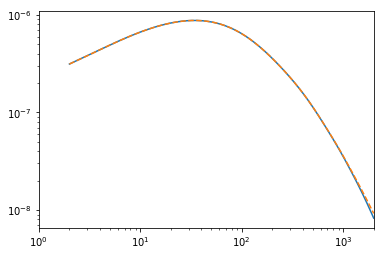

In [125]:
# this works again beautifully (some fudge factor still seems to be off, but okay)
ll = ell_
plt.loglog(ll,(ll*(ll+1.))**2*np.interp(ll,cllen['ell'],cllen['pp']))
plt.loglog(ell_,(ell_*(ell_+1))**2*Cl[-1,:],ls='--')
plt.loglog()
plt.xlim(1,2000)
# so I would expect that if I do steps 1-3 in post processing that this should work also! (but it doesnt)
# ergo: there must be a bug somewhere or my thinking is wrong